In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms.functional import crop
from PIL import Image
import json
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import numpy as np

In [ ]:
class Block(nn.Module):
  def __init__(self, in_c, out_c, kernel, stride=1, pad=0):
    super().__init__()

    self.act = nn.GELU()
    self.conv = nn.Conv2d(in_c, out_c, kernel, stride, pad)
    self.norm = nn.BatchNorm2d(out_c)

  def forward(self, x):
    out = self.conv(x)
    out = self.norm(out)
    out = self.act(out)
    return out

In [ ]:
class UnetBlock(nn.Module):
  def __init__(self, n_c, out_c, low_block=None):
    super().__init__()

    self.cv1 = Block(n_c, out_c, 3, stride=2, pad=2)
    self.cv2 = Block(n_c*2, int(out_c/2), 1, stride=1, pad=0)
    self.cv3 = Block(n_c, int(out_c/2), 5, stride=1, pad=3)

  def forward(self, x, unpooled_x):

    out = self.cv1(x)
    out = self.cv2(out)
    out = self.cv3(out)

    _,_,h,w = out.shape
    out = F.interpolate(out, size=(h*2,w*2), mode='bilinear')
    croped_x = crop(unpooled_x, 0 ,0, h*2, w*2)

    all_features = torch.cat((out, croped_x), axis=1)

    return all_features




In [ ]:
class UnetCut(nn.Module):
  def __init__(self):
    super().__init__()
    # image nxn input
    self.act = nn.GELU()
    #top level
    self.cv1 = Block(1, 128, 3, stride=1, pad=0)
    self.cv2 = Block(128, 64, 1, stride=1, pad=0)
    self.cv3 = Block(64, 64, 5, stride=1, pad=1)

    #low level
    self.pl = nn.MaxPool2d(2)
    self.inner_block = UnetBlock(64,128)

    # top level(after long skip connection)
    self.cv7 = Block(128, 64, 3, stride=1, pad=0)
    self.cv8 = Block(64, 64, 3, stride=1, pad=0)
    self.cv9 = Block(64, 1, 1, stride=1, pad=0)

  def forward(self, x):
    up_x = self.cv1(x)
    up_x = self.cv2(up_x)
    up_x = self.cv3(up_x)


    low_x = self.pl(up_x)

    all_features = self.inner_block(low_x, up_x)
    all_features = self.act(all_features)

    del up_x
    del low_x
    print(all_features.shape)
    all_features = self.cv7(all_features)
    print(all_features.shape)
    all_features = self.cv8(all_features)
    print(all_features.shape)
    all_features = self.cv9(all_features)
    print(all_features.shape)
    return all_features


In [ ]:
ten = torch.rand(1,1,512,512)
ten.shape

torch.Size([1, 1, 512, 512])

In [ ]:
t = crop(ten, 0,0,260,260)
t.shape

torch.Size([1, 1, 260, 260])

In [ ]:
u = UnetCut()

In [ ]:
res = u.forward(ten)

torch.Size([1, 128, 260, 260])
torch.Size([1, 64, 258, 258])
torch.Size([1, 64, 256, 256])
torch.Size([1, 1, 256, 256])


In [ ]:
res = u.forward(ten)

torch.Size([1, 128, 18, 18])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 14, 14])
torch.Size([1, 1, 14, 14])


In [ ]:
with open('/content/drive/MyDrive/train/_annotations.coco.json') as file:
  data = json.load(file)

print(data)

{'info': {'year': '2023', 'version': '1', 'description': 'Exported from roboflow.com', 'contributor': '', 'url': 'https://public.roboflow.com/object-detection/undefined', 'date_created': '2023-08-19T04:37:54+00:00'}, 'licenses': [{'id': 1, 'url': 'https://creativecommons.org/licenses/by/4.0/', 'name': 'CC BY 4.0'}], 'categories': [{'id': 0, 'name': 'Tumor', 'supercategory': 'none'}, {'id': 1, 'name': '0', 'supercategory': 'Tumor'}, {'id': 2, 'name': '1', 'supercategory': 'Tumor'}], 'images': [{'id': 0, 'license': 1, 'file_name': '2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg', 'height': 640, 'width': 640, 'date_captured': '2023-08-19T04:37:54+00:00'}, {'id': 1, 'license': 1, 'file_name': '2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b74f2.jpg', 'height': 640, 'width': 640, 'date_captured': '2023-08-19T04:37:54+00:00'}, {'id': 2, 'license': 1, 'file_name': '2921_jpg.rf.3b952f91f27a6248091e7601c22323ad.jpg', 'height': 640, 'width': 640, 'date_captured': '2023-08-19T04:37:54+00:00'}, {'id': 

In [ ]:
print(data['images'][0])

{'id': 0, 'license': 1, 'file_name': '2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg', 'height': 640, 'width': 640, 'date_captured': '2023-08-19T04:37:54+00:00'}


In [ ]:
dir_path = "/content/drive/MyDrive/train"

In [ ]:
 img_data = data['images'][0]


In [ ]:
def imagePath(dir_path, img_data):
  file_name = img_data['file_name']
  path = os.path.join(dir_path, file_name)
  return path



In [ ]:
def get_annotations(img_data, annotations):

  img_annotations = [ann for ann in annotations if ann['image_id'] == img_data['id']]
  return img_annotations




In [ ]:
annot = get_annotations(img_data, data['annotations'])
annot

[{'id': 0,
  'image_id': 0,
  'category_id': 1,
  'bbox': [145, 239, 168.75, 162.5],
  'area': 27421.875,
  'segmentation': [[313.75,
    238.75,
    145,
    238.75,
    145,
    401.25,
    313.75,
    401.25,
    313.75,
    238.75]],
  'iscrowd': 0}]

In [ ]:
for i, img in enumerate(data['images']):
  print(i, img)
  break

0 {'id': 0, 'license': 1, 'file_name': '2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg', 'height': 640, 'width': 640, 'date_captured': '2023-08-19T04:37:54+00:00'}


In [ ]:
def show_areas(dir, data,n):
  annotations = data['annotations']
  fig , ax = plt.subplots(n,1, figsize=(20,20))
  i = 0
  for img in data['images'][:n]:
    path = imagePath(dir, img)
    try:
      path_checking = Image.open(path)
    except FileNotFoundError:
      print('file is not found, skipping...')
      continue
    draw_img = cv2.imread(path)
    img_annotations = get_annotations(img, annotations)
    points = img_annotations[0]['segmentation']
    points = np.array(points, np.int64)
    points = points.reshape((-1,2))
    cv2.polylines(draw_img, [points], True, (255,0,0), 3)
    ax[i].imshow(draw_img)
    ax[i].axis('off')
    i += 1
  plt.show()

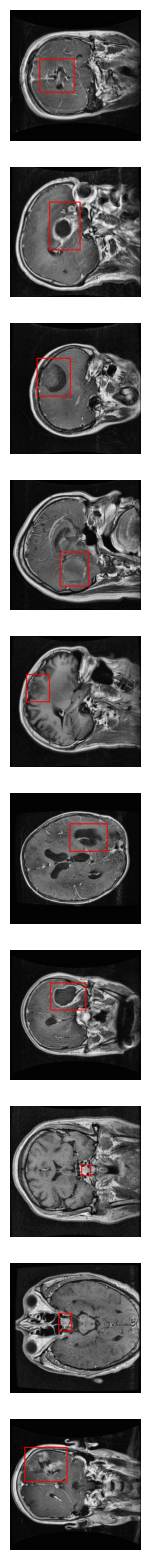

In [ ]:
show_areas(dir_path, data, 10)

In [ ]:
def create_masks(data, dir, output_dir):
  annotations = data['annotations']
  for img in data['images']:
    mask_path = os.path.join(output_dir, img['file_name'])
    path = imagePath(dir, img)
    try:
      path_checking = Image.open(path)
    except FileNotFoundError:
      print('file is not found, skipping...')
      continue
    mask = np.zeros((img['height'], img['width']), dtype=np.uint8)
    img_annotations = get_annotations(img, annotations)
    for ann in img_annotations:
      for seg in ann['segmentation']:
        poly = np.int64(np.array(seg).reshape(-1,2))
        cv2.fillPoly(mask, [poly.astype(np.int32)], color=(255,0,0))
    Image.fromarray(mask*255).save(mask_path)




In [ ]:
create_masks(data, dir_path, "/content/sample_data/masks")